# LAB 03:  Basic Feature Engineering in Keras 

**Learning Objectives**


1. Create an input pipeline using tf.data
2. Engineer features to create categorical, crossed, and numerical feature columns




## Introduction 
In this lab, we utilize feature engineering to improve the prediction of housing prices using a Keras Sequential Model.  

Each learning objective will correspond to a __#TODO__ in the notebook where you will complete the notebook cell's code before running. Refer to the [solution](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/feature_engineering/solutions/3_keras_basic_feat_eng.ipynb) for reference. 


Start by importing the necessary libraries for this lab.

In [1]:
!sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
# Install Sklearn
!python3 -m pip install --user sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=8283fc4f7b8ae4a4b7cf2b37fc41324f9b41e1306ef2c82f55b98e478b8af72a
  Stored in directory: /home/jupyter/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [3]:
# Ensure the right version of Tensorflow is installed.
!pip freeze | grep tensorflow==2.1 || pip install tensorflow==2.1

     |████████████████████████████████| 421.8 MB 16 kB/s s eta 0:00:011
     |████████████████████████████████| 448 kB 61.3 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 55.7 MB/s eta 0:00:01
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7538 sha256=061af3de1c87d05cf16013eef2c68e04468072d92028b26ccacc89a8209b9cfc
  Stored in directory: /home/jupyter/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully unins

**Note:** Please ignore any incompatibility warnings and errors and re-run the cell to view the installed tensorflow version.
`tensorflow==2.1.0` that is the installed version of tensorflow.

In [4]:
import os
import tensorflow.keras

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column as fc
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from keras.utils import plot_model

print("TensorFlow version: ",tf.version.VERSION)

Using TensorFlow backend.


TensorFlow version:  2.1.0


Many of the Google Machine Learning Courses Programming Exercises use the  [California Housing Dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description
), which contains data drawn from the 1990 U.S. Census.  Our lab dataset has been pre-processed so that there are no missing values.

First, let's download the raw .csv data by copying the data from a cloud storage bucket.


In [5]:
if not os.path.isdir("../data"):
    os.makedirs("../data")

In [6]:
!gsutil cp gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv ../data    

Copying gs://cloud-training-demos/feat_eng/housing/housing_pre-proc.csv...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      


In [7]:
!ls -l ../data/

total 1404
-rw-r--r-- 1 jupyter jupyter 1435069 May 27 00:53 housing_pre-proc.csv


Now, let's read in the dataset just copied from the cloud storage bucket and create a Pandas dataframe.

In [8]:
housing_df = pd.read_csv('../data/housing_pre-proc.csv', error_bad_lines=False)
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We can use .describe() to see some summary statistics for the numeric fields in our dataframe. Note, for example, the count row and corresponding columns. The count shows 20433.000000 for all feature columns. Thus, there are no missing values.

In [9]:
housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


####  Split the dataset for ML

The dataset we loaded was a single CSV file. We will split this into train, validation, and test sets.


In [10]:
train, test = train_test_split(housing_df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

13076 train examples
3270 validation examples
4087 test examples


Now, we need to output the split files.  We will specifically need the test.csv later for testing.  You should see the files appear in the home directory.


In [11]:
train.to_csv('../data/housing-train.csv', encoding='utf-8', index=False)

In [12]:
val.to_csv('../data/housing-val.csv', encoding='utf-8', index=False)

In [13]:
test.to_csv('../data/housing-test.csv', encoding='utf-8', index=False)

In [14]:
!head ../data/housing*.csv

==> ../data/housing-test.csv <==
longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-117.23,34.51,9.0,5756.0,807.0,2158.0,758.0,5.5875,167800.0,INLAND
-118.55,34.19,36.0,978.0,170.0,475.0,192.0,4.675,222500.0,<1H OCEAN
-121.94,38.41,15.0,1263.0,211.0,665.0,208.0,4.5,260900.0,INLAND
-117.05,32.57,22.0,2857.0,516.0,2412.0,496.0,4.7337,127600.0,NEAR OCEAN
-117.97,33.82,26.0,2335.0,504.0,1121.0,502.0,2.9891,205200.0,<1H OCEAN
-117.06,32.66,33.0,3425.0,511.0,1528.0,479.0,5.6889,234600.0,NEAR OCEAN
-118.32,34.03,31.0,2206.0,501.0,1194.0,435.0,1.9531,227800.0,<1H OCEAN
-118.24,33.98,37.0,1196.0,364.0,1622.0,327.0,2.125,108900.0,<1H OCEAN
-118.28,33.98,45.0,1720.0,416.0,1382.0,365.0,0.9337,92300.0,<1H OCEAN

==> ../data/housing-train.csv <==
longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
-117.72,34.08,34.0,2742.0,491.0,176

## Lab Task 1: Create an input pipeline using tf.data

Next, we will wrap the dataframes with [tf.data](https://www.tensorflow.org/guide/datasets). This will enable us  to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. 

Here, we create an input pipeline using tf.data.  This function is missing two lines.  Correct and run the cell.

In [18]:
# A utility method to create a tf.data dataset from a Pandas Dataframe

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    
    # TODO 1a -- Your code here
    labels = dataframe.pop('median_house_value')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))

    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

In [29]:
dict(train)['ocean_proximity']

5968         INLAND
14416    NEAR OCEAN
17717     <1H OCEAN
14078    NEAR OCEAN
17111    NEAR OCEAN
            ...    
3097         INLAND
18546        INLAND
8751      <1H OCEAN
11322    NEAR OCEAN
410        NEAR BAY
Name: ocean_proximity, Length: 13076, dtype: object

Next we initialize the training and validation datasets.

In [20]:
batch_size = 32
train_ds = df_to_dataset(train)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

Now that we have created the input pipeline, let's call it to see the format of the data it returns. We have used a small batch size to keep the output readable.

We can see that the dataset returns a dictionary of column names (from the dataframe) that map to column values from rows in the dataframe.

#### Numeric columns
The output of a feature column becomes the input to the model. A numeric is the simplest type of column. It is used to represent real valued features. When using this column, your model will receive the column value from the dataframe unchanged.

In the California housing prices dataset, most columns from the dataframe are numeric.  Let' create a variable called **numeric_cols** to hold only the numerical feature columns.

In [30]:
# TODO 1c -- Your code here
num_c = ['longitude', 
 'latitude',
 'housing_median_age', 
 'total_rooms', 
 'total_bedrooms',
 'population', 
 'households', 
 'median_income']

#### Scaler function
It is very important for numerical variables to get scaled before they are "fed" into the neural network. Here we use min-max scaling. Here we are creating a function named 'get_scal' which takes a list of numerical features and returns a 'minmax' function, which will be used in tf.feature_column.numeric_column() as normalizer_fn in parameters. 'Minmax' function itself takes a 'numerical' number from a particular feature and return scaled value of that number. 

Next, we scale the numerical feature columns that we assigned to the variable "numeric cols".

In [31]:
# Scalar def get_scal(feature):
# TODO 1d -- Your code here
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
    return(minmax)

In [35]:
# TODO 1e -- Your code here
feature_columns = []
for feature in num_c:
    scal_input_fn = get_scal(feature)
    feature_columns.append(fc.numeric_column(feature, normalizer_fn=scal_input_fn))

Next, we should validate the total number of feature columns.  Compare this number to the number of numeric features you input earlier.

In [37]:
print('Total number of feature coLumns: ', len(feature_columns))
print(feature_columns)

Total number of feature coLumns:  8
[NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_scal.<locals>.minmax at 0x7f64f06f0440>), NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_scal.<locals>.minmax at 0x7f64f06f0e60>), NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_scal.<locals>.minmax at 0x7f64f06f0ef0>), NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_scal.<locals>.minmax at 0x7f64f06f0f80>), NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_scal.<locals>.minmax at 0x7f64f05fb050>), NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function get_scal.<locals>.minmax at 0x7f64f05fb0e0>), NumericColumn(key='households', shape=(1,

### Using the Keras Sequential Model

Next, we will run this cell to compile and fit the Keras Sequential model.

In [38]:
# Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Train for 409 steps, validate for 103 steps
Epoch 1/32
409/409 [==============================] - 1s 3ms/step - loss: 55997610276.2612 - mse: 55989751808.0000 - val_loss: 56759170415.8447 - val_mse: 56830648320.0000
Epoch 2/32
409/409 [==============================] - 1s 2ms/step - loss: 55904040579.4417 - mse: 55923445760.0000 - val_loss: 56615022631.7670 - val_mse: 56686366720.0000
Epoch 3/32
409/409 [==============================] - 1s 2ms/step - loss: 55665621373.0992 - mse: 55669829632.0000 - val_loss: 56233567401.0097 - val_mse: 56304517120.0000
Epoch 4/32
409/409 [==============================] - 1s 2ms/step - loss: 55158064205.8056 - mse: 55150260224.0000 - val_loss: 55555978289.7087 - val_mse: 55626260480.0000
Epoch 5/32
409/409 [==============================] - 1s 2ms/step - loss: 54328868695.6526 - mse: 54322532352.0000 - val_loss: 54553927361.8641 - val_mse: 54623203328.0000
Epoch 6/32
409/409 [==============================] - 1s 2ms/step - loss: 53178320109.9582 - mse

Next we show loss as  Mean Square Error (MSE).  Remember that MSE is the most commonly used regression loss function. MSE is the sum of squared distances between our target variable (e.g. housing median age) and predicted values.

In [39]:
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

409/409 [==============================] - 1s 1ms/step - loss: 11950679058.7775 - mse: 11950886912.0000
Mean Squared Error 11950887000.0


#### Visualize the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.  A line plot is also created showing the mean squared error loss over the training epochs for both the train (blue) and test (orange) sets.

In [40]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');  

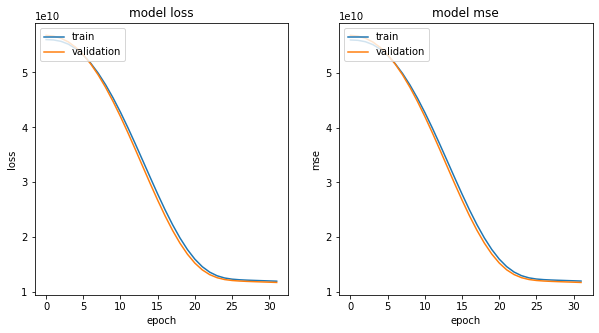

In [41]:
plot_curves(history, ['loss', 'mse'])

### Load test data

Next, we read in the test.csv file and validate that there are no null values.  

Again, we can use .describe() to see some summary statistics for the numeric fields in our dataframe.  The count shows 4087.000000 for all feature columns. Thus, there are no missing values.

In [42]:
test_data = pd.read_csv('../data/housing-test.csv')
test_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000
mean,-119.545236,35.612992,28.269391,2647.184487,536.649131,1426.912161,497.224370,3.888176,206451.527282
std,2.005069,2.127943,12.658495,2175.442741,400.451673,1069.017844,357.204918,1.908844,115375.867476
min,-124.300000,32.550000,1.000000,16.000000,4.000000,8.000000,3.000000,0.536000,22500.000000
25%,-121.770000,33.930000,18.000000,1444.500000,298.000000,799.000000,283.000000,2.559700,119900.000000
50%,-118.480000,34.250000,28.000000,2123.000000,437.000000,1175.000000,412.000000,3.578100,177700.000000
75%,-117.970000,37.710000,37.000000,3206.500000,654.000000,1729.000000,612.000000,4.737900,262350.000000
max,-114.470000,41.860000,52.000000,39320.000000,6210.000000,16305.000000,5358.000000,15.000100,500001.000000


Now that we have created an input pipeline using tf.data and compiled a Keras Sequential Model, we now create the input function for the test data and to initialize the test_predict variable.

In [62]:
print(test_data.keys())

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')


In [63]:
# TODO 1f -- Your code here
def test_input_fn(testd):
    return df_to_dataset(testd, False)

In [64]:
test_predict = test_input_fn(dict(test_data))
print(test_predict)

<BatchDataset shapes: ({longitude: (None,), latitude: (None,), housing_median_age: (None,), total_rooms: (None,), total_bedrooms: (None,), population: (None,), households: (None,), median_income: (None,), ocean_proximity: (None,)}, (None,)), types: ({longitude: tf.float64, latitude: tf.float64, housing_median_age: tf.float64, total_rooms: tf.float64, total_bedrooms: tf.float64, population: tf.float64, households: tf.float64, median_income: tf.float64, ocean_proximity: tf.string}, tf.float64)>


#### Prediction:  Linear Regression

Before we begin to feature engineer our feature columns, we should predict the median house value.  By predicting the median house value now, we can then compare it with the median house value after feature engineering.

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the housing features you want to predict the median_house_value for. Note:  We are predicting the model locally.

In [65]:
predicted_median_house_value = model.predict(test_predict)

Next, we run two predictions in separate cells - one where ocean_proximity=INLAND and one where ocean_proximity= NEAR OCEAN. 

In [66]:
# Ocean_proximity is INLAND
model.predict({
    'longitude': tf.convert_to_tensor([-121.86]),
    'latitude': tf.convert_to_tensor([39.78]),
    'housing_median_age': tf.convert_to_tensor([12.0]),
    'total_rooms': tf.convert_to_tensor([7653.0]),
    'total_bedrooms': tf.convert_to_tensor([1578.0]),
    'population': tf.convert_to_tensor([3628.0]),
    'households': tf.convert_to_tensor([1494.0]),
    'median_income': tf.convert_to_tensor([3.0905]),
    'ocean_proximity': tf.convert_to_tensor(['INLAND'])
}, steps=1)

array([[228141.23]], dtype=float32)

In [67]:
# Ocean_proximity is NEAR OCEAN
model.predict({
    'longitude': tf.convert_to_tensor([-122.43]),
    'latitude': tf.convert_to_tensor([37.63]),
    'housing_median_age': tf.convert_to_tensor([34.0]),
    'total_rooms': tf.convert_to_tensor([4135.0]),
    'total_bedrooms': tf.convert_to_tensor([687.0]),
    'population': tf.convert_to_tensor([2154.0]),
    'households': tf.convert_to_tensor([742.0]),
    'median_income': tf.convert_to_tensor([4.9732]),
    'ocean_proximity': tf.convert_to_tensor(['NEAR OCEAN'])
}, steps=1)

array([[224335.81]], dtype=float32)

The arrays returns a predicted value.  What do these numbers mean?  Let's compare this value to the test set.  

Go to the test.csv you read in a few cells up.  Locate the first line and find the median_house_value - which should be 249,000 dollars near the ocean. What value did your model predicted for the median_house_value? Was it a solid model performance? Let's see if we can improve this a bit with feature engineering!  


## Lab Task 2: Engineer features to create categorical and numerical features

Now we create a cell that indicates which features will be used in the model.  
Note:  Be sure to bucketize 'housing_median_age' and ensure that 'ocean_proximity' is one-hot encoded.  And, don't forget your numeric values!

In [70]:
# TODO 2a -- Your code here
numeric_cols = ['longitude', 
 'latitude',
 'housing_median_age', 
 'total_rooms', 
 'total_bedrooms',
 'population', 
 'households', 
 'median_income']

bucketized_cols = ['housing_median_age']
categorized_cols = ['ocean_proximity']

Next, we scale the numerical, bucktized, and categorical feature columns that we assigned to the variables in the preceding cell.

In [71]:
# Scalar def get_scal(feature):
def get_scal(feature):
    def minmax(x):
        mini = train[feature].min()
        maxi = train[feature].max()
        return (x - mini)/(maxi-mini)
        return(minmax)

In [72]:
# All numerical features - scaling
feature_columns = []
for header in numeric_cols:
    scal_input_fn = get_scal(header)
    feature_columns.append(fc.numeric_column(header,
                                             normalizer_fn=scal_input_fn))

### Categorical Feature
In this dataset, 'ocean_proximity' is represented as a string.  We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector.

Next, we create a categorical feature using 'ocean_proximity'.

In [76]:
# TODO 2b -- Your code here
for feature_name in categorized_cols:
    vocabulary = train[feature_name].unique()
    cat_c = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)
    one_hot = tf.feature_column.indicator_column(cat_c)
    feature_columns.append(one_hot)

### Bucketized Feature

Often, you don't want to feed a number directly into the model, but instead split its value into different categories based on numerical ranges. Consider our raw data that represents a homes' age. Instead of representing the house age as a numeric column, we could split the home age into several buckets using a [bucketized column](https://www.tensorflow.org/api_docs/python/tf/feature_column/bucketized_column). Notice the one-hot values below describe which age range each row matches.

Next we create a bucketized column using 'housing_median_age'


In [84]:
# TODO 2c -- Your code here
age = fc.numeric_column("housing_median_age")
age_buckets = tf.feature_column.bucketized_column(
 age, 
 boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65]
)
feature_columns.append(age_buckets)

### Feature Cross

Combining features into a single feature, better known as [feature crosses](https://developers.google.com/machine-learning/glossary/#feature_cross), enables a model to learn separate weights for each combination of features.

Next, we create a feature cross of 'housing_median_age' and 'ocean_proximity'.

In [ ]:
# TODO 2d -- Your code here
tf.feature_column.crossed_column([age_buckets, ])

Next, we should validate the total number of feature columns.  Compare this number to the number of numeric features you input earlier.

In [ ]:
print('Total number of feature columns: ', len(feature_columns))

Next, we will run this cell to compile and fit the Keras Sequential model.  This is the same model we ran earlier.

In [ ]:
# Model create
feature_layer = tf.keras.layers.DenseFeatures(feature_columns,
                                              dtype='float64')

model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(12, input_dim=8, activation='relu'),
  layers.Dense(8, activation='relu'),
  layers.Dense(1, activation='linear',  name='median_house_value')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=32)

Next, we show loss and mean squared error then plot the model.

In [ ]:
loss, mse = model.evaluate(train_ds)
print("Mean Squared Error", mse)

In [ ]:
plot_curves(history, ['loss', 'mse'])

Next we create a prediction model.  Note:  You may use the same values from the previous prediciton.  

In [ ]:
# TODO 2e -- Your code here


### Analysis 

The array returns a predicted value.  Compare this value to the test set you ran earlier. Your predicted value may be a bit better.

Now that you have your "feature engineering template" setup, you can experiment by creating additional features.  For example, you can create derived features, such as households per population, and see how they impact the model.  You can also experiment with replacing the features you used to create the feature cross.
 

Copyright 2020 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.